In [1]:
from math import *
import numpy as np
import random

In [45]:
class Simplex:
        
    def __init__(self, vertices, params, function, 
                 values = np.zeros(3), transf = ""):
        self.vertices = vertices        
        self.values = values
        # initialize ordering
        self.ord_vs = np.argsort(self.values)
        self.cm = 0.5*(self.vertices[self.ord_vs[0]] + 
                       self.vertices[self.ord_vs[1]])
        self.params = params
        self.transformation = transf
        self.f = function
        
    def get_centroid(self):
        centr = np.sum(self.vertices, axis=0) / 3
        return centr, self.f(centr[0], centr[1])
    
    def get_figure(self):
        codes = [Path.MOVETO, Path.LINETO, 
                 Path.LINETO,  Path.CLOSEPOLY ]
        return Path(np.append(self.vertices, 
                    [self.vertices[0]], axis=0), codes)
    
    def get_best(self):
        ''' This method return the best vertex of 
        the simplex and it's value '''
        return (self.vertices[self.ord_vs[0]], 
                self.values[self.ord_vs[0]] )
        
    def redefine_worst_vertex(self, new_vertex, 
                              new_value, transformation):
        return Simplex(
            vertices = np.append(np.delete(self.vertices, self.ord_vs[2], axis=0)
                                 ,[new_vertex], axis= 0),
            params = self.params,
            values   = np.append(np.delete(self.values, 
                   self.ord_vs[2], axis=0), [new_value], axis = 0),
            transf = transformation,
            function = self.f
        )
        
    
    def evaluate(self):
        '''This function evaluate the simplex vertices and orders them'''
        self.values =  self.f(self.vertices[:,0], self.vertices[:,1])
        self.ord_vs = np.argsort(self.values)
        #set the center of mass of the two best vertices
        self.cm = 0.5*(self.vertices[self.ord_vs[0]] + 
                       self.vertices[self.ord_vs[1]])
        return self.values, self.ord_vs
    
    
    def reflect_and_expand(self):
        ''' Reflect the worst vertex and try to expand the simplex'''
        refl_vert = self.cm + self.params["reflect"]*(self.cm - self.vertices[self.ord_vs[2]])
        refl_value = self.f(refl_vert[0], refl_vert[1])
        # new array of values, excluding the worst vertex
        if refl_value > self.values[self.ord_vs[2]]:
            # worst than best two elements
            return None
        elif refl_value < self.values[self.ord_vs[1]] and refl_value > self.values[self.ord_vs[0]]:
            # This is the new best simplex
            return self.redefine_worst_vertex(refl_vert, refl_value, "reflect")
        elif refl_value < self.values[self.ord_vs[0]]:
            # we try to expand
            expand_vert = self.cm + self.params["expand"]*(self.cm - self.vertices[self.ord_vs[2]])
            expand_value = self.f(expand_vert[0], expand_vert[1])
            if expand_value > refl_value:
                # the expansion is even better
                return self.redefine_worst_vertex(expand_vert, expand_value, "expand")
            else:
                # return the simplex with only reflection
                return self.redefine_worst_vertex(refl_vert, refl_value, "reflec")
            
            
    def contract(self):
        ''' Contract the the third vertex towards the worst one'''
        contract_vert = self.cm + self.params["contract"]*(self.vertices[self.ord_vs[2]] - self.cm)
        #print(contract_vert, self.vertices, self.cm)
        contract_value = self.f(contract_vert[0], contract_vert[1])
        # check if the contracted vertex if better than worst one
        if contract_value < self.values[self.ord_vs[2]]:
            return self.redefine_worst_vertex(contract_vert, contract_value, "contract")
        else: 
            return None
        
    
    def redefine(self):
        ''' Redefine the simplex towards the best vertex '''
        best = self.vertices[self.ord_vs[0]]
        new_v1 = best + self.params["redefine"]*( self.vertices[self.ord_vs[1]] - best)
        new_v2 = best + self.params["redefine"]*( self.vertices[self.ord_vs[2]] - best)
        new_value1 = self.f(new_v1[0], new_v1[1])
        new_value2 = self.f(new_v2[0], new_v2[1])
        #print(best, self.vertices[self.ord_vs[1]], new_v1)
        return Simplex(
            vertices = np.array([self.vertices[self.ord_vs[0]], new_v1, new_v2]),
            params = self.params,
            values = np.array([self.values[self.ord_vs[0]], new_value1, new_value2]),
            transf = "redefine",
            function = self.f
        )
            
    def __repr__(self):
        return "Vertices: {} \nValues: {}\nOrder: {}".format(self.vertices, self.values, self.ord_vs)

In [3]:
def f_easom(x, y):
    return -cos(x)*cos(y)*exp(-((x-pi)**2 + (y-pi)**2))

def f_goldestein(x,y):
    return exp(0.5*((x**2+y**2 -25)**2)) +(sin(4*x-3*y))**4 +0.5*((2*x+y-10)**2)

def f_bokin(x,y):
    return 100*sqrt(abs(y-0.01* (x**2))) +0.01* abs(x+10)

def f_booth(x, y):
    return (x+2*y-7)**2 + (2*x + y -5)**2

vf_easom = np.vectorize(f_easom)
vf_goldestein = np.vectorize(f_goldestein)
vf_bokin = np.vectorize(f_bokin)
vf_booth = np.vectorize(f_booth)

In [4]:
def err_relative(old, new):
    old_l = np.power(np.sum(np.power(old,2)),0.5)
    err = np.power(np.sum(np.power(old - new,2)),0.5)
    return err / old_l

In [5]:
def process_simplex(initial_vertices, function, precision, params={"reflect": 1, "expand":2, "contract":0.5, "redefine": 0.5}):
    # Create the first simplex
    s = Simplex(initial_vertices, params, function, transf="initial" )
    # First evaluation
    s.evaluate()
    # Get the centroid to control the precision
    centroid, value_centroid = s.get_centroid()
    # Save the intermediate steps
    simplexes = [s]
    
    while(True):
        s2 = s.reflect_and_expand()
        if not s2:
            s2 = s.contract()
            if not s2:
                s2 = s.redefine()
        simplexes.append(s2)
        s = s2
        new_centroid, new_value_centroid = s.get_centroid()
        if  abs(new_value_centroid - value_centroid)/abs(value_centroid) < precision:
            print("Function precision limit")
            break
        if err_relative(centroid, new_centroid) < precision:
            print("Movement step limit")
            break
        centroid = new_centroid
        value_centroid = new_value_centroid
    
    return simplexes    

In [15]:
initial_vertices = np.array([ [-3,-3], [-4,-5], [1,2]])

In [8]:
s = process_simplex(initial_vertices, vf_booth, 1e-15)
print("Steps: ",len(s))
print(s[-1])

Movement step limit
Steps:  127
Vertices: [[1. 3.]
 [1. 3.]
 [1. 3.]] 
Values: [4.86727179e-28 5.82179348e-28 1.53039016e-28]
Order: [2 0 1]


In [9]:
s = process_simplex(initial_vertices, vf_easom, 1e-15)
print("Steps: ",len(s))
print(s[-1])

Function precision limit
Steps:  125
Vertices: [[3.14159267 3.14159285]
 [3.14159251 3.14159259]
 [3.14159266 3.14159256]] 
Values: [-1. -1. -1.]
Order: [2 1 0]


In [9]:
initial_vertices = np.array([ [-0.4,0.5], [0.2,0.3], [0.2,0.5]])
s = process_simplex(initial_vertices, vf_goldestein, 1e-15)
print("Steps: ",len(s))
print(s[-1])

Function precision limit
Steps:  303
Vertices: [[2.01153738 4.60692063]
 [2.01153738 4.60692067]
 [2.01153741 4.60692066]] 
Values: [2.03179625 2.03179625 2.03179625]
Order: [2 1 0]


In [27]:
initial_vertices = np.array([[1,0.05], [-0.5,0.4], [-0.5,-0.05]])
s = process_simplex(initial_vertices, vf_bokin, 1e-15)
print("Steps: ",len(s))
print(s[-1])

Movement step limit
Steps:  60
Vertices: [[0.0390625  0.        ]
 [0.40632629 0.00166016]
 [0.2226944  0.00083008]] 
Values: [0.49101563 0.40648149 1.93020446]
Order: [1 0 2]


# Visualization

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

#%matplotlib notebook
mpl.rc('figure', titlesize=30)
mpl.rc('axes', labelsize=18)
mpl.rc('axes', grid=True)
mpl.rc('grid', linestyle=':')
mpl.rc('legend', fontsize=20)
mpl.rc('figure', figsize=(12, 8))


Function precision limit


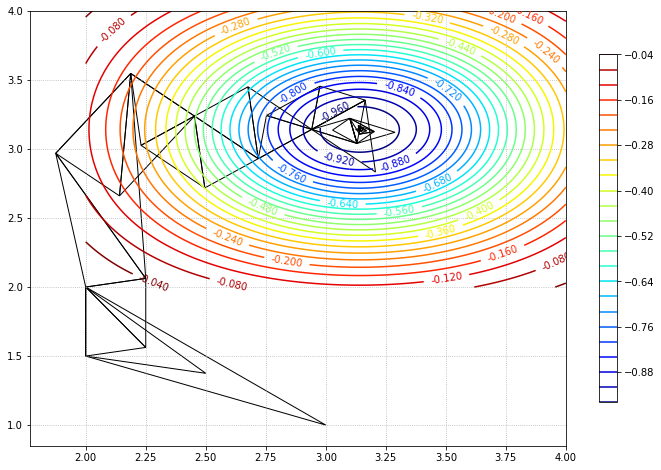

Values: [-1. -1. -1.]
Vertices: [[3.14159279 3.14159272]
 [3.14159254 3.14159271]
 [3.1415927  3.1415926 ]]


In [30]:
x = np.linspace(2, 4, 500)
y = np.linspace(2, 4, 500)
X, Y = np.meshgrid(x, y)
z = vf_easom(X, Y)

initial_vertices = np.array([[2,2],[2,1.5],[3,1]])
s = process_simplex(initial_vertices, vf_easom, 1e-15)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(s)):
    patch = patches.PathPatch(s[i].get_figure(),facecolor='none', lw=1)
    ax.add_patch(patch)

CS = plt.contour(X, Y, z, 30,cmap="jet")
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

print("Values: {}\nVertices: {}".format(s[-1].values, s[-1].vertices))

Function precision limit


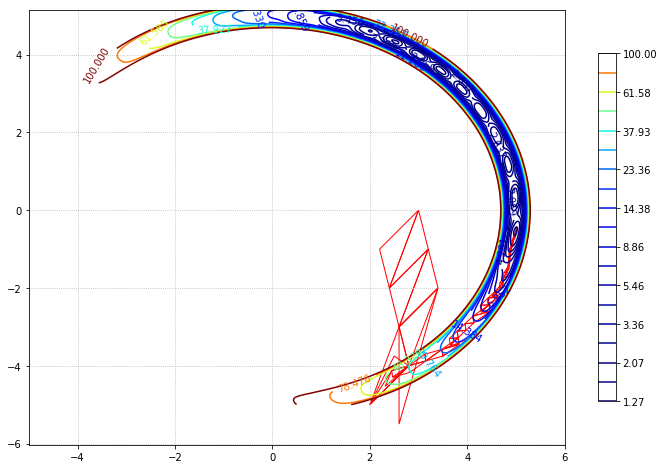

Values: [1.20042884 1.20042884 1.20042884]
Vertices: [[ 4.99254492 -0.53155722]
 [ 4.9925449  -0.53155721]
 [ 4.9925449  -0.53155723]]


In [17]:
x = np.linspace(-5, 6, 500)
y = np.linspace(-5, 5.15, 500)
X, Y = np.meshgrid(x, y)
z = vf_goldestein(X, Y)

initial_vertices = np.array([[2.2,-1],[2.4, -2], [3,0]])
s = process_simplex(initial_vertices, vf_goldestein, 1e-15)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(s)):
    patch = patches.PathPatch(s[i].get_figure(),facecolor='none', edgecolor='r', lw=1)
    ax.add_patch(patch)

CS = plt.contour(X, Y, z, 20,levels = np.logspace(0, 2, 20),cmap="jet")
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.clabel(CS, inline=1, fontsize=10)
plt.show()
print("Values: {}\nVertices: {}".format(s[-1].values, s[-1].vertices))

Function precision limit


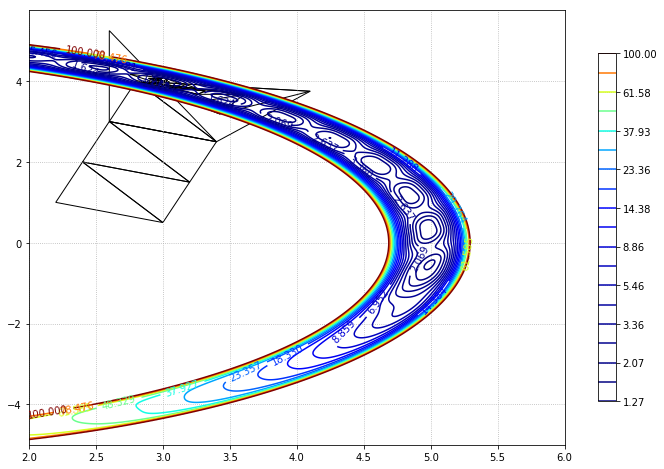

Values: [1. 1. 1.]
Vertices: [[3.00000014 3.99999988]
 [2.99999996 4.00000004]
 [2.99999996 4.00000002]]


In [18]:
x = np.linspace(2, 6, 500)
y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)
z = vf_goldestein(X, Y)

initial_vertices = np.array([[2.2,1],[2.4, 2], [3,0.5]])
s = process_simplex(initial_vertices, vf_goldestein, 1e-15)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(s)):
    patch = patches.PathPatch(s[i].get_figure(),facecolor='none', lw=1)
    ax.add_patch(patch)

CS = plt.contour(X, Y, z, 20,levels = np.logspace(0, 2, 20),cmap="jet")
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

print("Values: {}\nVertices: {}".format(s[-1].values, s[-1].vertices))

Movement step limit


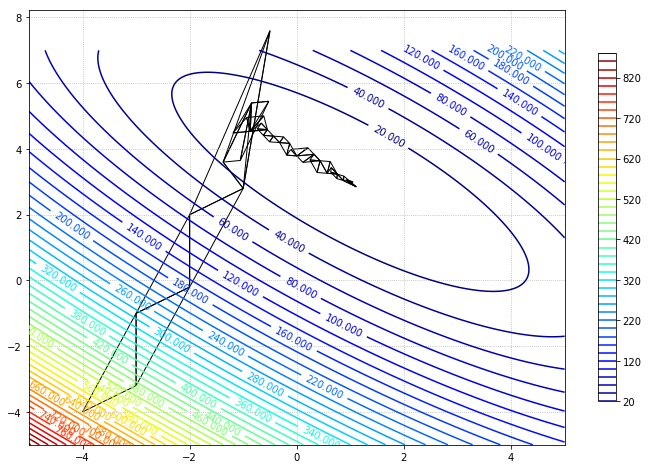

Values: [1.54616737e-28 2.14570166e-28 1.54616737e-28]
Vertices: [[1. 3.]
 [1. 3.]
 [1. 3.]]


In [19]:
x = np.linspace(-5, 5, 500)
y = np.linspace(-5, 7, 500)
X, Y = np.meshgrid(x, y)
z = vf_booth(X, Y)

initial_vertices = np.array([[-4,-4], [-3,-1],[-3,-3.2]])
s = process_simplex(initial_vertices, vf_booth, 1e-15)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(s)):
    patch = patches.PathPatch(s[i].get_figure(),facecolor='none', lw=1)
    ax.add_patch(patch)

CS = plt.contour(X, Y, z, 50, cmap="jet")
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

print("Values: {}\nVertices: {}".format(s[-1].values, s[-1].vertices))

Movement step limit


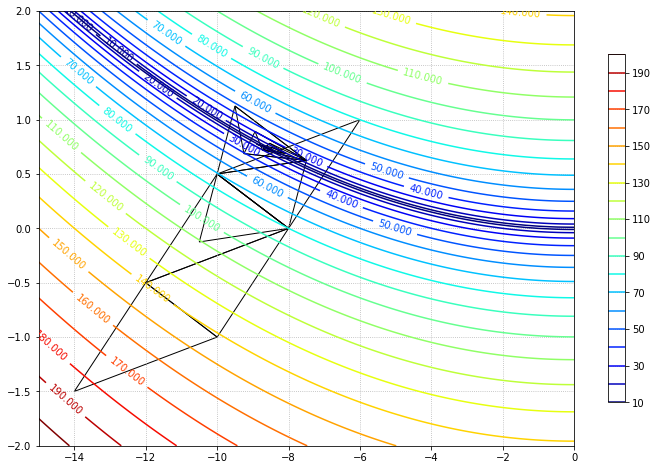

Values: [0.0139461  0.01394716 0.01394716]
Vertices: [[-8.60538977  0.74052733]
 [-8.60538977  0.74052733]
 [-8.60538977  0.74052733]]


In [46]:
x = np.linspace(-15, 0, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)
z = vf_bokin(X, Y)

initial_vertices = np.array([[-14,-1.5], [-12,-0.5],[-10,-1]])
#initial_vertices = np.array([[-4,-1.5], [-3,-0.5],[-3,-1]])
s = process_simplex(initial_vertices, vf_bokin, 1e-15)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(len(s)):
    patch = patches.PathPatch(s[i].get_figure(),facecolor='none', lw=1)
    ax.add_patch(patch)

CS = plt.contour(X, Y, z, 20,cmap="jet")
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

print("Values: {}\nVertices: {}".format(s[-1].values, s[-1].vertices))

# Random initialization and global minimum
Vogliamo trovare i diversi minimi locali e il minimo globale inizializzando in modo random la ricerca


## F easom
Utilizziamo la finestra (1,5)x(1,5).  Ci aspettiamo un solo minimo in $(\pi , \pi)$

In [28]:
minima = []

for i in range(100):
    v1 = [random.uniform(1,4), random.uniform(1,4)]
    v2 = [v1[0]+ random.uniform(-1,1), v1[1] + random.uniform(-1,1)]
    v3 = [v2[0]+ random.uniform(-1,1), v2[1] + random.uniform(-1,1)]
    initial_vertices = np.array([v1,v2,v3])
    try:
        s = process_simplex(initial_vertices, vf_easom, 1e-15)
    except:
        print("exception")
        continue
    minima.append(s[-1])

easom_minima =  np.array([v.get_best() for v in minima])

Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Movement step limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Movement step limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function p

Global minimum: [3.14159265 3.14159265] 
 Value : -0.9999999999999999


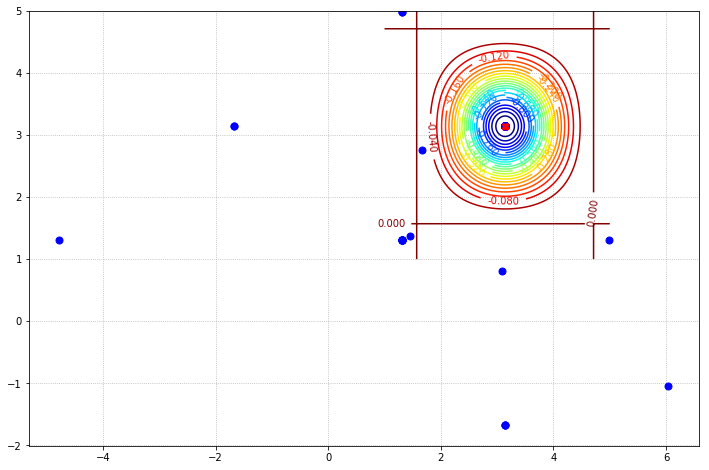

In [29]:
x = np.linspace(1, 5, 500)
y = np.linspace(1, 5, 500)
X, Y = np.meshgrid(x, y)
z = vf_easom(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111)


plt.plot([x[0] for x in easom_minima[:, 0]] , [x[1] for x in easom_minima[:, 0]] ,
         linestyle='None', marker="o", color="b", markersize=7)

CS = plt.contour(X, Y, z, 30,cmap="jet")
plt.clabel(CS, inline=1, fontsize=10)

global_minimum = easom_minima[np.argsort(easom_minima[:,1])[0]]
print("Global minimum: {} \n Value : {}".format(global_minimum[0], global_minimum[1]))

plt.plot(global_minimum[0][0], global_minimum[0][1] , linestyle='None', 
         marker="X", color="r", markersize=7)
plt.show()

## F goldestein
Ci aspettiamo più minimi, usiamo finestra (-5,6)x(-5,6)

In [37]:
minima = []

for i in range(100):
    v1 = [random.uniform(-4,4), random.uniform(-4,4)]
    v2 = [v1[0]+ random.uniform(-2,2), v1[1] + random.uniform(-2,2)]
    v3 = [v2[0]+ random.uniform(-2,2), v2[1] + random.uniform(-2,2)]
    initial_vertices = np.array([v1,v2,v3])
    try:
        s = process_simplex(initial_vertices, vf_goldestein, 1e-15)
    except:
        print("exception")
        continue
    minima.append(s[-1])

goldestein_minima =  np.array([v.get_best() for v in minima])

Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
exception
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
exception
Function precision limit
Function precision limit
Function precision limit
Function precision limit
exception
Function precision limit
Function precision limit
Function precision limit
exception
Function precision limit
Function precision limit
Function precision limit
exception
Function precision limit
Function precision limit
Function precision limit


Global minimum: [2.99999998 4.00000001] 
 Value : 1.0000000000000002


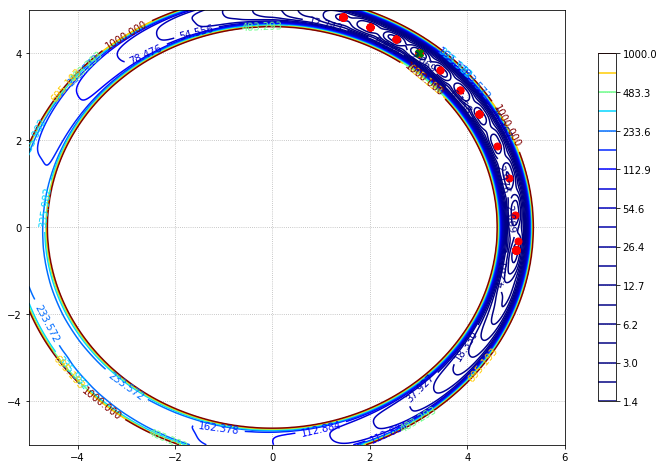

In [38]:
x = np.linspace(-5, 6, 500)
y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)
z = vf_goldestein(X, Y)


fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot([x[0] for x in goldestein_minima[:, 0]] , 
         [x[1] for x in goldestein_minima[:, 0]] ,
         linestyle='None', marker="o", color="r", markersize=7)


CS = plt.contour(X, Y, z, 20,levels = np.logspace(0, 3, 20),cmap="jet")
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.clabel(CS, inline=1, fontsize=10)

global_minimum = goldestein_minima[np.argsort(goldestein_minima[:,1])[0]]
print("Global minimum: {} \n Value : {}".format(global_minimum[0], global_minimum[1]))

plt.plot(global_minimum[0][0], global_minimum[0][1] , linestyle='None', 
         marker="X", color="g", markersize=8)
plt.show()

# F Bokin 
Utilizziamo una finestra ( -20, +20)x(-1,3)

In [39]:
minima = []

for i in range(100): 
    v1 = [random.uniform(-19,19), random.uniform(0,2)]
    v2 = [v1[0]+ random.uniform(-1,1), v1[1] + random.uniform(-1,1)]
    v3 = [v2[0]+ random.uniform(-1,1), v2[1] + random.uniform(-1,1)]
    initial_vertices = np.array([v1,v2,v3])
    try:
        s = process_simplex(initial_vertices, vf_bokin, 1e-15)
    except:
        print("exception")
        continue
    minima.append(s[-1])

bokin_minima =  np.array([v.get_best() for v in minima])

Movement step limit
Movement step limit
Movement step limit
Movement step limit
Function precision limit
Movement step limit
Function precision limit
Function precision limit
Function precision limit
Movement step limit
Movement step limit
Function precision limit
Movement step limit
Function precision limit
Movement step limit
Function precision limit
Function precision limit
Movement step limit
Movement step limit
Function precision limit
Movement step limit
Movement step limit
Movement step limit
Function precision limit
Function precision limit
Movement step limit
Movement step limit
Function precision limit
Function precision limit
Movement step limit
Movement step limit
Function precision limit
Function precision limit
Function precision limit
Function precision limit
Movement step limit
Movement step limit
Function precision limit
Movement step limit
Function precision limit
Function precision limit
Function precision limit
Movement step limit
Movement step limit
Movement step l

Global minimum: [-10.02434326   1.00487458] 
 Value : 0.00024343262779799702


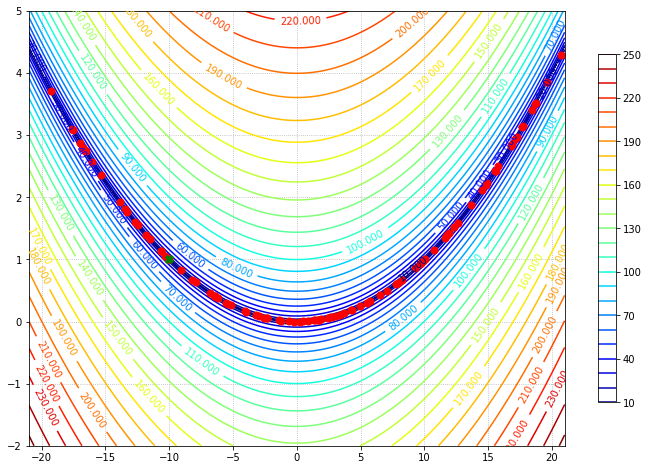

In [41]:
x = np.linspace(-21,+21, 500)
y = np.linspace(-2,5 , 500)
X, Y = np.meshgrid(x, y)
z = vf_bokin(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111)


plt.plot([x[0] for x in bokin_minima[:, 0]] , 
         [x[1] for x in bokin_minima[:, 0]] , 
         linestyle='None', marker="o", color="r", markersize=7)

CS = plt.contour(X, Y, z, 30, cmap="jet")
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.clabel(CS, inline=1, fontsize=10)

global_minimum = bokin_minima[np.argsort(bokin_minima[:,1])[0]]
print("Global minimum: {} \n Value : {}".format(global_minimum[0], global_minimum[1]))

plt.plot(global_minimum[0][0], global_minimum[0][1] , 
         linestyle='None', marker="X", color="g", markersize=8)
plt.show()

# F Booth
Finestra ( -4, 5)x(-2, 8)

In [42]:
minima = []

for i in range(100):
    v1 = [random.uniform(-3,4), random.uniform(-1,7)]
    v2 = [v1[0]+ random.uniform(-1,1), v1[1] + random.uniform(-1,1)]
    v3 = [v2[0]+ random.uniform(-1,1), v2[1] + random.uniform(-1,1)]
    initial_vertices = np.array([v1,v2,v3])
    try:
        s = process_simplex(initial_vertices, vf_booth, 1e-15)
    except:
        print("exception")
        continue
    minima.append(s[-1])

booth_minima =  np.array([v.get_best() for v in minima])

Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Function precision limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Function precision limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement s

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit
Movement step limit


Global minimum: [1. 3.] 
 Value : 1.4199496293978212e-29


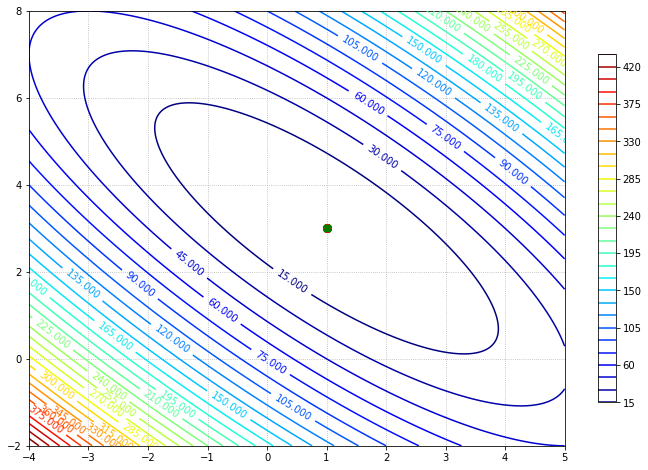

In [44]:
x = np.linspace(-4,+5, 500)
y = np.linspace(-2, 8, 500)
X, Y = np.meshgrid(x, y)
z = vf_booth(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111)


plt.plot([x[0] for x in booth_minima[:, 0]] , 
         [x[1] for x in booth_minima[:, 0]] , 
         linestyle='None', marker="o", color="r", markersize=7)

CS = plt.contour(X, Y, z, 30, cmap='jet')
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.clabel(CS, inline=1, fontsize=10)

global_minimum = booth_minima[np.argsort(booth_minima[:,1])[0]]
print("Global minimum: {} \n Value : {}".format(global_minimum[0], global_minimum[1]))

plt.plot(global_minimum[0][0], global_minimum[0][1], 
         linestyle='None', marker="X", color="g", markersize=8)
plt.show()